# Second COMP421 Assignment

Suggestion: just edit and add cells to this, and submit a notebook? Give it a name that _starts with your name_, such as Frean_SecondAssignment.ipynb

Please submit using the usual ECS [submission system](https://apps.ecs.vuw.ac.nz/submit/COMP421).

### What this is about
"Autoencoders" are neural networks which attempt to reproduce their input at their output, after having passed the information through some form of bottleneck, such as a hidden layer having fewer units than the input. They are trained in the usual way (in this case, by doing gradient descent on the sum of squared errors), so in a sense they're just regular backprop networks. What makes them interesting is the _encoding_ of the inputs that results. The mapping from input to the bottleneck layer can be thought of as an "encoder" and, from there to the output as a "decoder". To the extent that the network succeeds in reproducing the input, it has captured the essential structure in the encoding, ie. the hidden layer activations.

So when you learn an autoencoder, using the classic supervised learning algorithm of backpropagation, you're really doing a form of _unsupervised_ learning: in the learning process the network is "discovering" a compact encoding of the dataset.

### PREP: get comfortable with autograd
 
autograd is probably the best thing since sliced bread. You write some function, then autograd will give you a function that takes the gradient of it. Here is an example: [autograd on sin function](https://github.com/garibaldu/comp421/blob/master/notebooks/autograd_example.ipynb). For part B here you will write your own neural network's forward pass and loss function, and use autograd to find the gradient for use in Stochastic Gradient Descent. 

(No more messing about with awkward buggy gradient calculations! No more tearing that loaf apart with your bare hands!)

### A: Principal Components Analysis

Find the first few Principal Components of the sklearn digits data (ie. the data from  the [kNN example](https://github.com/garibaldu/comp421/blob/master/notebooks/knn_on_little_digits.ipynb)), and show them as images. It doesn't really matter how you do this - perhaps sklearn itself can do it for you?

In [1]:
import autograd.numpy as np
import sklearn.datasets as ds
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
digits = ds.load_digits()
X = digits.data
print(X.shape)

(1797, 64)


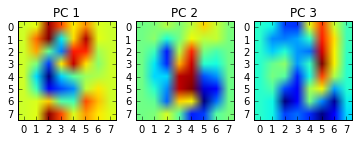

In [54]:
desired_num_components = 3

# Calculate the non-normalised principal components of the digits
# data.
pca = PCA(n_components=desired_num_components)
pca.fit(X)

fig = plt.figure()
for i in range(desired_num_components):
    fig.add_subplot(1, desired_num_components, i + 1)
    plt.imshow(np.reshape(pca.components_[i], (8, 8)))
    plt.title("PC " + str(i + 1))

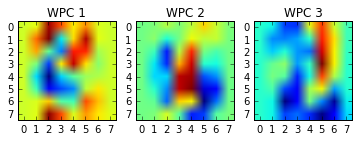

In [53]:
# Now calculate the whitened (normalised) principal components of the
# digits data.
pca = PCA(n_components=desired_num_components, whiten=True)
pca.fit(X)

fig = plt.figure()
for i in range(desired_num_components):
    fig.add_subplot(1, desired_num_components, i + 1)
    plt.imshow(np.reshape(pca.components_[i], (8, 8)))
    plt.title("WPC " + str(i + 1))

### B: autoencoding with linear hidden layer
   1. use autograd to learn a neural network that is entirely linear, with inputs _and outputs_ being the sklearn digits, and a single hidden unit. Show the input and output weights: are they the same as the first principal component?
   1. now freeze that unit's weights (both in and out) and learn a second hidden unit.  Show the input and output weights: are they the same as the second principal component?
   1. now train the whole thing at once, instead of unit-by-unit. Are the results different?
   1. account for what you see.

In [6]:
from autograd import grad
from autograd.util import flatten_func

In [48]:
batch_size = 128
num_epochs = 5000
step_size = 0.001

num_batches = int(np.ceil(X.shape[0] / batch_size))

In [56]:
def init_weights(architecture):
    """Returns a list of weights for each layer
    in the neural network.
    """
    return [np.random.randn(m, n) 
            for m, n in zip(architecture[:-1], architecture[1:])]

def neural_net_predict(params, inputs, nonlin=None):
    """Performs a forward pass through a neural network. 
    
    If the nonlin flag is set, then the weighted sum are 
    transformed into activations using the specified
    activation function.
    """
    for W in params:
        outputs = np.dot(inputs, W)
        inputs = nonlin(outputs) if nonlin else outputs
            
    return outputs

def sse(target, predicted):
    """The sum of squared errors between the predicted values
    and targets.
    """
    return np.mean((target - predicted)**2)
    
def batch_indices(iter):
    idx = iter % num_batches
    return slice(idx * batch_size, (idx + 1) * batch_size)

def objective(params, iter):
    idx = batch_indices(iter)
    inputs = X[idx]
    predicted = neural_net_predict(params, inputs)
    # Since we're training an autoencoder, the targets are 
    # equal to the inputs.
    return sse(inputs, predicted)

grad_objective = grad(objective)

def rmsprop(grad, init_params, callback=None, num_iters=100,
            step_size=0.1, gamma=0.9, eps=10**-8):
    """Root mean squared prop: See Adagrad paper for details.
    """
    flattened_grad, unflatten, x = flatten_func(grad, init_params)

    avg_sq_grad = np.ones(len(x))
    for i in range(num_iters):
        g = flattened_grad(x, i)
        if callback: callback(i)
        avg_sq_grad = avg_sq_grad * gamma + g**2 * (1 - gamma)
        x = x - step_size * g/(np.sqrt(avg_sq_grad) + eps)
    return unflatten(x)

def adam(grad, init_params, callback=None, num_iters=100,
         step_size=0.001, b1=0.9, b2=0.999, eps=10**-8):
    """Adam as described in http://arxiv.org/pdf/1412.6980.pdf.
    It's basically RMSprop with momentum and some correction terms.
    """
    flattened_grad, unflatten, x = flatten_func(grad, init_params)

    m = np.zeros(len(x))
    v = np.zeros(len(x))
    for i in range(num_iters):
        g = flattened_grad(x, i)
        if callback: callback(i)
        m = (1 - b1) * g      + b1 * m  # First  moment estimate.
        v = (1 - b2) * (g**2) + b2 * v  # Second moment estimate.
        mhat = m / (1 - b1**(i + 1))    # Bias correction.
        vhat = v / (1 - b2**(i + 1))
        x = x - step_size*mhat/(np.sqrt(vhat) + eps)
    return unflatten(x)

def print_progress(iter):
    if iter % num_batches == 0:
        workdone = iter / (num_epochs * num_batches)
        print("\rTraining: [{0:50s}] {1:.1f}%".format('#' * int(workdone * 50), workdone*100), end="", flush=True)

In [57]:
# An autoencoder with one hidden layer, containing just one
# hidden unit.
architecture = [X.shape[1], 1, X.shape[1]]

weights = init_weights(architecture)

optimized_params = rmsprop(grad_objective, init_params=weights, step_size=step_size,
                       num_iters=(num_epochs * num_batches), callback=print_progress)

Training: [################################################# ] 100.0%

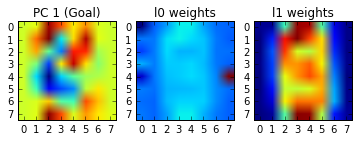

In [58]:
num_params = len(optimized_params)

fig = plt.figure()
fig.add_subplot(1, num_params + 1, 1)
plt.imshow(np.reshape(pca.components_[0], (8, 8)))
plt.title("PC 1 (Goal)")
for i in range(num_params):
    fig.add_subplot(1, num_params + 1, i + 2)
    plt.imshow(np.reshape(optimized_params[i], (8, 8)))
    plt.title("l" + str(i) + " weights")

### C: the effect of nonlinearities
   1. now do the same (training all at once) with a hidden layer that involves a non-linearity (e.g. sigmoid, or relu).
   1. account for what you see.